### Scaling Preprocessing Task

##### 표정 분류

https://drive.google.com/file/d/1lpwQNwijBfaSr8knSNHKWu5KUmzYWU9d/view?usp=drive_link

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import preprocess_input

IMAGE_SIZE = 150
BATCH_SIZE = 64

image_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

root = './datasets/face/original/'
original_generator = image_data_generator.flow_from_directory(root, target_size=(IMAGE_SIZE, IMAGE_SIZE), batch_size=BATCH_SIZE, class_mode='categorical', shuffle=True)
print(original_generator.class_indices)
print(original_generator.classes)

root = './datasets/face/test/'
test_generator = image_data_generator.flow_from_directory(root, target_size=(IMAGE_SIZE, IMAGE_SIZE), batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)
print(test_generator.class_indices)
print(test_generator.classes)

Found 28709 images belonging to 7 classes.
{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
[0 0 0 ... 6 6 6]
Found 7178 images belonging to 7 classes.
{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
[0 0 0 ... 6 6 6]


In [3]:
target_name = {v: k for k, v in original_generator.class_indices.items()}
target_name

{0: 'angry',
 1: 'disgust',
 2: 'fear',
 3: 'happy',
 4: 'neutral',
 5: 'sad',
 6: 'surprise'}

In [4]:
original_target_names = []
test_target_names = []

for target in original_generator.classes:
    original_target_names.append(target_name[target])

for target in test_generator.classes:
    test_target_names.append(target_name[target])
    
print(original_target_names.__len__(), test_target_names.__len__())

28709 7178


In [5]:
import pandas as pd

original_df = pd.DataFrame({'file_paths': original_generator.filepaths, 'target_names': original_target_names, 'targets': original_generator.classes})
original_df.file_paths = original_df.file_paths.apply(lambda file_path: file_path.replace('\\', '/'))

test_df = pd.DataFrame({'file_paths': test_generator.filepaths, 'target_names': test_target_names, 'targets': test_generator.classes})
test_df.file_paths = test_df.file_paths.apply(lambda file_path: file_path.replace('\\', '/'))

display(original_df)
display(test_df)

,file_paths,target_names,targets
0,./datasets/face/original/angry/Training_101184...,angry,0
1,./datasets/face/original/angry/Training_101204...,angry,0
2,./datasets/face/original/angry/Training_101313...,angry,0
3,./datasets/face/original/angry/Training_101615...,angry,0
4,./datasets/face/original/angry/Training_102183...,angry,0
...,...,...,...
28704,./datasets/face/original/surprise/Training_999...,surprise,6
28705,./datasets/face/original/surprise/Training_999...,surprise,6
28706,./datasets/face/original/surprise/Training_999...,surprise,6
28707,./datasets/face/original/surprise/Training_999...,surprise,6


,file_paths,target_names,targets
0,./datasets/face/test/angry/PrivateTest_1013136...,angry,0
1,./datasets/face/test/angry/PrivateTest_1030447...,angry,0
2,./datasets/face/test/angry/PrivateTest_1054527...,angry,0
3,./datasets/face/test/angry/PrivateTest_1059009...,angry,0
4,./datasets/face/test/angry/PrivateTest_1109992...,angry,0
...,...,...,...
7173,./datasets/face/test/surprise/PublicTest_98089...,surprise,6
7174,./datasets/face/test/surprise/PublicTest_98567...,surprise,6
7175,./datasets/face/test/surprise/PublicTest_98972...,surprise,6
7176,./datasets/face/test/surprise/PublicTest_99242...,surprise,6


In [6]:
from sklearn.model_selection import train_test_split

train_images, validation_images, train_targets, validation_targets = train_test_split(original_df.file_paths, original_df.targets, stratify=original_df.targets, test_size=0.2, random_state=124)

print(train_targets.value_counts())
print(validation_targets.value_counts())

targets
3    5772
4    3972
5    3864
2    3277
0    3196
6    2537
1     349
Name: count, dtype: int64
targets
3    1443
4     993
5     966
2     820
0     799
6     634
1      87
Name: count, dtype: int64


In [8]:
import shutil
import os.path

root = './datasets/face/'


for filepath in train_images:
    face_dir = filepath[filepath.find('original/') + 9:filepath.rindex('/')] + '/'
    destination = root + 'train/' + face_dir
    
    if not os.path.exists(destination):
        os.mkdir(destination)
    shutil.copy2(filepath, destination)

In [9]:
import shutil
import os.path

root = './datasets/face/'


for filepath in validation_images:
    face_dir = filepath[filepath.find('original/') + 9:filepath.rindex('/')] + '/'
    destination = root + 'validation/' + face_dir
    
    if not os.path.exists(destination):
        os.mkdir(destination)
    shutil.copy2(filepath, destination)

In [10]:
train_df = original_df.loc[train_images.index].reset_index(drop=True)
validation_df = original_df.loc[validation_images.index].reset_index(drop=True)

print(train_df.shape[0])
print(validation_df.shape[0])
print(test_df.shape[0])

22967
5742
7178


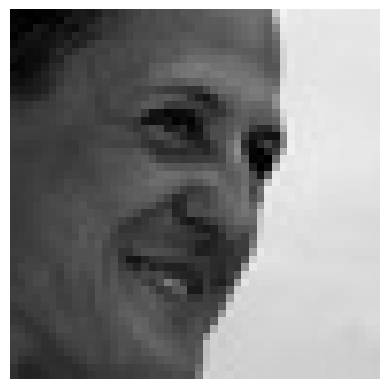

In [11]:
import cv2
import matplotlib.pyplot as plt

image = cv2.cvtColor(cv2.imread(train_df.file_paths.iloc[16000]), cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.axis('off')
plt.show()

In [13]:
from tensorflow.keras.applications.xception import preprocess_input

IMAGES_SIZE = 150
BATCH_SIZE = 64

train_generator = ImageDataGenerator(horizontal_flip=True, preprocessing_function=preprocess_input)
validation_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

train_flow = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='file_paths',
    y_col='target_names',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True
)

validation_flow = validation_generator.flow_from_dataframe(
    dataframe=validation_df,
    x_col='file_paths',
    y_col='target_names',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_flow = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='file_paths',
    y_col='target_names',
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

print(train_flow.class_indices)
print(validation_flow.class_indices)
print(test_flow.class_indices)

Found 22967 validated image filenames belonging to 7 classes.
Found 5742 validated image filenames belonging to 7 classes.
Found 7178 validated image filenames belonging to 7 classes.
{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [15]:
images_array, targets_array = next(train_flow)
print(images_array.shape, targets_array.shape)
images_array

(64, 150, 150, 3) (64, 7)


array([[[[ 0.7176471 ,  0.7176471 ,  0.7176471 ],
         [ 0.7176471 ,  0.7176471 ,  0.7176471 ],
         [ 0.7176471 ,  0.7176471 ,  0.7176471 ],
         ...,
         [-0.15294117, -0.15294117, -0.15294117],
         [-0.15294117, -0.15294117, -0.15294117],
         [-0.15294117, -0.15294117, -0.15294117]],

        [[ 0.7176471 ,  0.7176471 ,  0.7176471 ],
         [ 0.7176471 ,  0.7176471 ,  0.7176471 ],
         [ 0.7176471 ,  0.7176471 ,  0.7176471 ],
         ...,
         [-0.15294117, -0.15294117, -0.15294117],
         [-0.15294117, -0.15294117, -0.15294117],
         [-0.15294117, -0.15294117, -0.15294117]],

        [[ 0.7176471 ,  0.7176471 ,  0.7176471 ],
         [ 0.7176471 ,  0.7176471 ,  0.7176471 ],
         [ 0.7176471 ,  0.7176471 ,  0.7176471 ],
         ...,
         [-0.15294117, -0.15294117, -0.15294117],
         [-0.15294117, -0.15294117, -0.15294117],
         [-0.15294117, -0.15294117, -0.15294117]],

        ...,

        [[ 0.07450986,  0.07450986,  0

In [16]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense , Conv2D , Dropout , Flatten , Activation, MaxPooling2D , GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications import Xception

def create_model(model_name='vgg16', verbose=False):
    
    input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    if model_name == 'vgg16':
        base_model = VGG16(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'resnet50':
        base_model = ResNet50V2(input_tensor=input_tensor, include_top=False, weights='imagenet')
    elif model_name == 'xception':
        base_model = Xception(input_tensor=input_tensor, include_top=False, weights='imagenet')
    
    bm_output = base_model.output

    x = GlobalAveragePooling2D()(bm_output)
    if model_name != 'vgg16':
        x = Dropout(rate=0.5)(x)
    x = Dense(50, activation='relu')(x)
    output = Dense(7, activation='softmax', name='output')(x)

    model = Model(inputs=input_tensor, outputs=output)
    
    if verbose:
        model.summary()
        
    return model

In [17]:
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy

model = create_model(model_name='xception', verbose=True)
model.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=['acc'])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 74, 74, 32)           864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 74, 74, 32)           128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 74, 74, 32)           0         ['block1_conv1_bn[0][0]'] 

                                                                                                  
 block4_sepconv2_act (Activ  (None, 18, 18, 728)          0         ['block4_sepconv1_bn[0][0]']  
 ation)                                                                                           
                                                                                                  
 block4_sepconv2 (Separable  (None, 18, 18, 728)          536536    ['block4_sepconv2_act[0][0]'] 
 Conv2D)                                                                                          
                                                                                                  
 block4_sepconv2_bn (BatchN  (None, 18, 18, 728)          2912      ['block4_sepconv2[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 conv2d_2 

                                                                                                  
 block7_sepconv1 (Separable  (None, 9, 9, 728)            536536    ['block7_sepconv1_act[0][0]'] 
 Conv2D)                                                                                          
                                                                                                  
 block7_sepconv1_bn (BatchN  (None, 9, 9, 728)            2912      ['block7_sepconv1[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 block7_sepconv2_act (Activ  (None, 9, 9, 728)            0         ['block7_sepconv1_bn[0][0]']  
 ation)                                                                                           
                                                                                                  
 block7_se

 ormalization)                                                                                    
                                                                                                  
 add_7 (Add)                 (None, 9, 9, 728)            0         ['block9_sepconv3_bn[0][0]',  
                                                                     'add_6[0][0]']               
                                                                                                  
 block10_sepconv1_act (Acti  (None, 9, 9, 728)            0         ['add_7[0][0]']               
 vation)                                                                                          
                                                                                                  
 block10_sepconv1 (Separabl  (None, 9, 9, 728)            536536    ['block10_sepconv1_act[0][0]']
 eConv2D)                                                                                         
          

 block12_sepconv3_act (Acti  (None, 9, 9, 728)            0         ['block12_sepconv2_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 block12_sepconv3 (Separabl  (None, 9, 9, 728)            536536    ['block12_sepconv3_act[0][0]']
 eConv2D)                                                                                         
                                                                                                  
 block12_sepconv3_bn (Batch  (None, 9, 9, 728)            2912      ['block12_sepconv3[0][0]']    
 Normalization)                                                                                   
                                                                                                  
 add_10 (Add)                (None, 9, 9, 728)            0         ['block12_sepconv3_bn[0][0]', 
          

In [18]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

mcp_cb = ModelCheckpoint(
    filepath='./callback_files/weights.{epoch:03d}-{val_loss:.4f}.h5', 
    monitor='val_loss', 
    save_best_only=True, 
    save_weights_only=True, 
    mode='min', 
    verbose=1)

rlr_cb = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.1,
    patience=2, 
    mode='min', 
    verbose=1)

ely_cb = EarlyStopping(
    monitor='val_loss', 
    patience=4, 
    mode='min', 
    verbose=1)

In [19]:
import gc

gc.collect()

1687

In [20]:
N_EPOCHS = 10

history = model.fit(train_flow, epochs=N_EPOCHS,
          validation_data=validation_flow, 
          callbacks=[mcp_cb, rlr_cb, ely_cb])

Epoch 1/10
  3/359 [..............................] - ETA: 44:15 - loss: 1.8828 - acc: 0.2552

KeyboardInterrupt: 

In [ ]:
model.evaluate(test_flow)

In [ ]:
import matplotlib.pyplot as plt

def show_history(history):
    plt.figure(figsize=(6, 6))
    plt.yticks(np.arange(0, 1, 0.05))
    plt.plot(history.history['acc'], label='train')
    plt.plot(history.history['val_acc'], label='validation')
    plt.legend()
    
show_history(history)